In [1]:
from google.colab import drive
drive.mount('/content/drive')

import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize



nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

**PART 1: Data preparation**

In [2]:
docs_path = '/content/drive/Shareddrives/IRWA/P1/fashion_products_dataset.json'
with open(docs_path) as fp:
    data = json.load(fp)

In [3]:
print("Total number of fashion products:", len(data))

Total number of fashion products: 28080


In [17]:
df = pd.DataFrame(data)

clean_df = df.copy()

clean_df.drop(columns=['_id', 'crawled_at'], errors='ignore', inplace=True)

desired_order = ['pid', 'title', 'description', 'brand', 'category', 'sub_category','product_details', 'seller', 'out_of_stock', 'selling_price',
    'discount', 'actual_price', 'average_rating', 'url']

clean_df = clean_df[[col for col in desired_order if col in clean_df.columns]]

def clean_selling_price(value):
    """Convert to float and divide by 10 to make sense the price"""
    try:
        return float(value)/10
    except:
        return None

def clean_actual_price(value):
    """Turn commas to points and convert to float. Also multiply by 10 to make sense the price"""
    if isinstance(value, str):
        value = value.replace(',', '.').strip()
    try:
        return float(value)*10
    except:
        return None

def clean_discount(value):
    """Convert '76% off' → 76.0"""
    if isinstance(value, str):
        value = value.replace('%', '').replace('off', '').strip()
    try:
        return float(value)
    except:
        return None

def clean_rating(value):
    """Convert rating string to float"""
    try:
        return float(value)
    except:
        return None

def clean_product_details(value):
    """
    Converteix el contingut de la columna 'product_details' en un sol text.
    Exemple d'entrada:
      [{'Style Code': '1005COMBO2'}, {'Closure': 'Elastic'}]
    Retorna:
      'Style Code 1005COMBO2 Closure Elastic'
    """
    if isinstance(value, list):
        return " ".join(f"{k} {v}" for d in value for k, v in d.items())
    return str(value)

clean_df['selling_price']  = clean_df['selling_price'].apply(clean_selling_price)
clean_df['actual_price']   = clean_df['actual_price'].apply(clean_actual_price)
clean_df['discount']       = clean_df['discount'].apply(clean_discount)
clean_df['average_rating'] = clean_df['average_rating'].apply(clean_rating)
clean_df['product_details'] = clean_df['product_details'].apply(clean_product_details)

display(clean_df.head())
clean_df.to_csv("/content/drive/Shareddrives/IRWA/P1/clean_df.csv", index=False)



,pid,title,description,brand,category,sub_category,product_details,seller,out_of_stock,selling_price,discount,actual_price,average_rating,url
0,TKPFCZ9EA7H5FYZH,Solid Women Multicolor Track Pants,Yorker trackpants made from 100% rich combed c...,York,Clothing and Accessories,Bottomwear,Style Code 1005COMBO2 Closure Elastic Pockets ...,Shyam Enterprises,False,92.1,69.0,29.99,3.9,https://www.flipkart.com/yorker-solid-men-mult...
1,TKPFCZ9EJZV2UVRZ,Solid Men Blue Track Pants,Yorker trackpants made from 100% rich combed c...,York,Clothing and Accessories,Bottomwear,"Style Code 1005BLUE Closure Drawstring, Elasti...",Shyam Enterprises,False,49.9,66.0,14.99,3.9,https://www.flipkart.com/yorker-solid-men-blue...
2,TKPFCZ9EHFCY5Z4Y,Solid Men Multicolor Track Pants,Yorker trackpants made from 100% rich combed c...,York,Clothing and Accessories,Bottomwear,Style Code 1005COMBO4 Closure Elastic Pockets ...,Shyam Enterprises,False,93.1,68.0,29.99,3.9,https://www.flipkart.com/yorker-solid-men-mult...
3,TKPFCZ9ESZZ7YWEF,Solid Women Multicolor Track Pants,Yorker trackpants made from 100% rich combed c...,York,Clothing and Accessories,Bottomwear,Style Code 1005COMBO3 Closure Elastic Pockets ...,Shyam Enterprises,False,91.1,69.0,29.99,3.9,https://www.flipkart.com/yorker-solid-men-mult...
4,TKPFCZ9EVXKBSUD7,"Solid Women Brown, Grey Track Pants",Yorker trackpants made from 100% rich combed c...,York,Clothing and Accessories,Bottomwear,"Style Code 1005COMBO1 Closure Drawstring, Elas...",Shyam Enterprises,False,94.3,68.0,29.99,3.9,https://www.flipkart.com/yorker-solid-men-brow...


In [18]:
def preproces_text(text):
    if not isinstance(text, str):
        return []

    stop_words = set(stopwords.words('english'))
    stemmer = PorterStemmer()
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t.isalpha()]
    tokens = [t for t in tokens if t not in stop_words]
    tokens = [stemmer.stem(t) for t in tokens]

    return tokens

processed_df = clean_df.copy()

text_columns = ["title","description","brand","category","sub_category","product_details","seller"]

for col in text_columns:
    processed_df[col] = processed_df[col].apply(preproces_text)

display(processed_df.head())

processed_df.to_csv("/content/drive/Shareddrives/IRWA/P1/processed_df.csv", index=False)

,pid,title,description,brand,category,sub_category,product_details,seller,out_of_stock,selling_price,discount,actual_price,average_rating,url
0,TKPFCZ9EA7H5FYZH,"[solid, women, multicolor, track, pant]","[yorker, trackpant, made, rich, comb, cotton, ...",[york],"[cloth, accessori]",[bottomwear],"[style, code, closur, elast, pocket, side, poc...","[shyam, enterpris]",False,92.1,69.0,29.99,3.9,https://www.flipkart.com/yorker-solid-men-mult...
1,TKPFCZ9EJZV2UVRZ,"[solid, men, blue, track, pant]","[yorker, trackpant, made, rich, comb, cotton, ...",[york],"[cloth, accessori]",[bottomwear],"[style, code, closur, drawstr, elast, pocket, ...","[shyam, enterpris]",False,49.9,66.0,14.99,3.9,https://www.flipkart.com/yorker-solid-men-blue...
2,TKPFCZ9EHFCY5Z4Y,"[solid, men, multicolor, track, pant]","[yorker, trackpant, made, rich, comb, cotton, ...",[york],"[cloth, accessori]",[bottomwear],"[style, code, closur, elast, pocket, side, poc...","[shyam, enterpris]",False,93.1,68.0,29.99,3.9,https://www.flipkart.com/yorker-solid-men-mult...
3,TKPFCZ9ESZZ7YWEF,"[solid, women, multicolor, track, pant]","[yorker, trackpant, made, rich, comb, cotton, ...",[york],"[cloth, accessori]",[bottomwear],"[style, code, closur, elast, pocket, side, poc...","[shyam, enterpris]",False,91.1,69.0,29.99,3.9,https://www.flipkart.com/yorker-solid-men-mult...
4,TKPFCZ9EVXKBSUD7,"[solid, women, brown, grey, track, pant]","[yorker, trackpant, made, rich, comb, cotton, ...",[york],"[cloth, accessori]",[bottomwear],"[style, code, closur, drawstr, elast, pocket, ...","[shyam, enterpris]",False,94.3,68.0,29.99,3.9,https://www.flipkart.com/yorker-solid-men-brow...


**PART 2: Exploratory Data Analysis**

In [6]:
print("Dataset Shape:", clean_df.shape)
print("\nColumn Names:", clean_df.columns.tolist())
print("\nData Types:")
print(clean_df.dtypes)
print("\nMissing Values:")
print(clean_df.isnull().sum())

Dataset Shape: (28080, 14)

Column Names: ['pid', 'title', 'description', 'brand', 'category', 'sub_category', 'product_details', 'seller', 'out_of_stock', 'selling_price', 'discount', 'actual_price', 'average_rating', 'url']

Data Types:
pid                 object
title               object
description         object
brand               object
category            object
sub_category        object
product_details     object
seller              object
out_of_stock          bool
selling_price      float64
discount           float64
actual_price       float64
average_rating     float64
url                 object
dtype: object

Missing Values:
pid                   0
title                 0
description           0
brand                 0
category              0
sub_category          0
product_details       0
seller                0
out_of_stock          0
selling_price      4113
discount            855
actual_price        777
average_rating     2261
url                   0
dtype: int64


In [7]:
numerical_cols = ['selling_price', 'discount', 'actual_price', 'average_rating']
print("Numerical Variables Summary:")
print(clean_df[numerical_cols].describe())

Numerical Variables Summary:
       selling_price      discount  actual_price  average_rating
count   23967.000000  27225.000000  27303.000000    25819.000000
mean       53.542563     50.256896   3475.707739        3.627724
std        21.176260     16.887287   4115.209061        0.663429
min         9.900000      1.000000     10.000000        1.000000
25%        35.900000     40.000000     15.990000        3.200000
50%        49.900000     53.000000     29.990000        3.800000
75%        69.900000     63.000000   7850.000000        4.100000
max        99.900000     87.000000   9990.000000        5.000000


In [8]:
categorical_cols = ['brand', 'category', 'sub_category', 'seller']
for col in categorical_cols:
    print(f"\n{col} - Unique values: {clean_df[col].nunique()}")
    print(f"Top 10 {col}:")
    print(clean_df[col].value_counts().head(10))


brand - Unique values: 325
Top 10 brand:
brand
                2009
ECKO Unl         951
Free Authori     860
ARBO             806
REEB             802
Pu               798
True Bl          793
Keo              660
Amp              585
Black Beat       548
Name: count, dtype: int64

category - Unique values: 4
Top 10 category:
category
Clothing and Accessories    27118
Footwear                      920
Bags, Wallets & Belts          41
Toys                            1
Name: count, dtype: int64

sub_category - Unique values: 24
Top 10 sub_category:
sub_category
Topwear                            15310
Bottomwear                          3666
Winter Wear                         2493
Innerwear and Swimwear              1762
Clothing Accessories                1742
Kurtas, Ethnic Sets and Bottoms     1180
Men's Footwear                       920
Fabrics                              534
Sleepwear                            122
Blazers, Waistcoats and Suits        103
Name: count, dtype: i

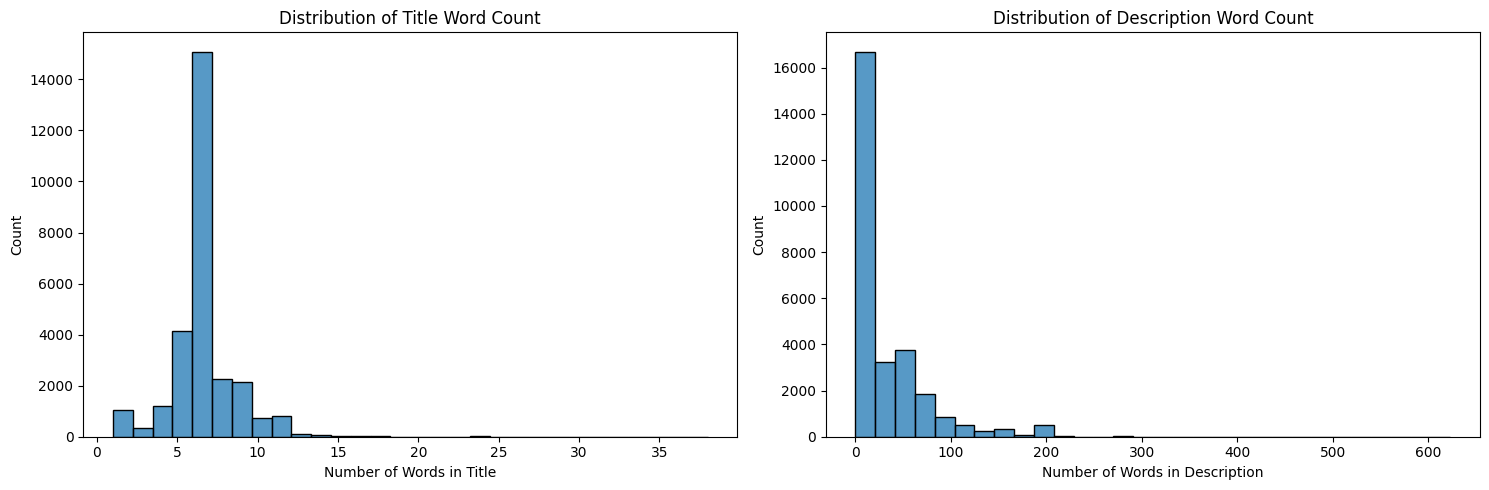

Average title length: 6.46 words
Average description length: 29.77 words


In [9]:

clean_df['title_length'] = clean_df['title'].str.split().str.len()
clean_df['description_length'] = clean_df['description'].str.split().str.len()

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.histplot(clean_df['title_length'].dropna(), bins=30)
plt.title('Distribution of Title Word Count')
plt.xlabel('Number of Words in Title')

plt.subplot(1, 2, 2)
sns.histplot(clean_df['description_length'].dropna(), bins=30)
plt.title('Distribution of Description Word Count')
plt.xlabel('Number of Words in Description')

plt.tight_layout()
plt.show()

print(f"Average title length: {clean_df['title_length'].mean():.2f} words")
print(f"Average description length: {clean_df['description_length'].mean():.2f} words")

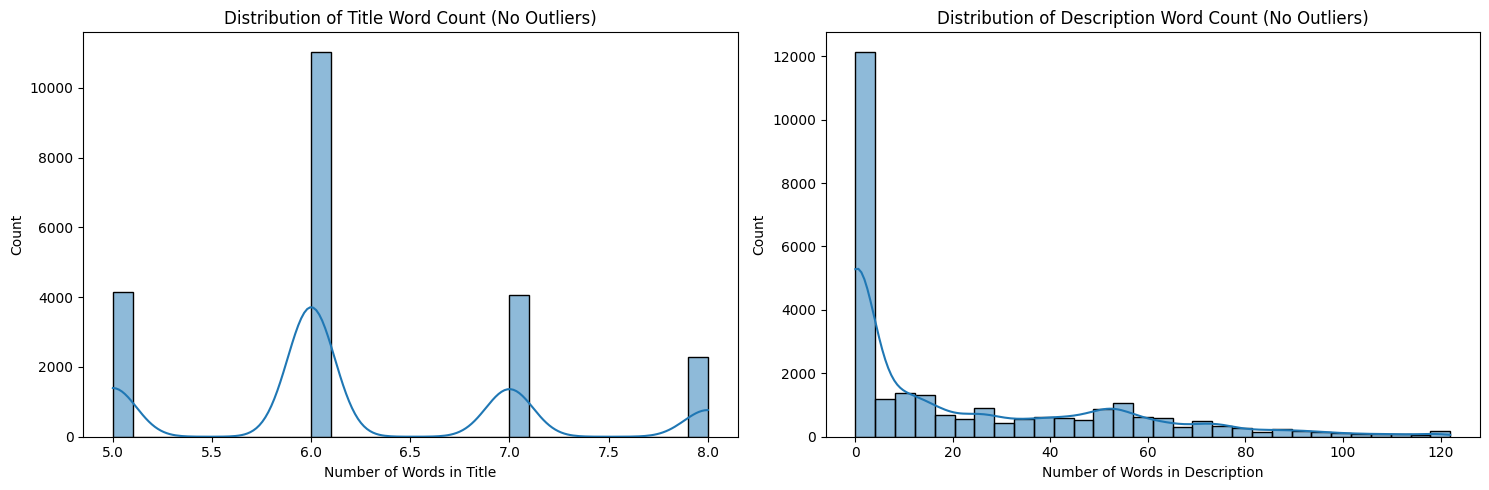

Average title length (no outliers): 6.21 words
Average description length (no outliers): 22.57 words


In [10]:


clean_df['title_length'] = clean_df['title'].str.split().str.len()
clean_df['description_length'] = clean_df['description'].str.split().str.len()

def remove_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return series[(series >= lower_bound) & (series <= upper_bound)]


title_lengths_clean = remove_outliers(clean_df['title_length'].dropna())
desc_lengths_clean = remove_outliers(clean_df['description_length'].dropna())

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.histplot(title_lengths_clean, bins=30, kde=True)
plt.title('Distribution of Title Word Count (No Outliers)')
plt.xlabel('Number of Words in Title')

plt.subplot(1, 2, 2)
sns.histplot(desc_lengths_clean, bins=30, kde=True)
plt.title('Distribution of Description Word Count (No Outliers)')
plt.xlabel('Number of Words in Description')

plt.tight_layout()
plt.show()

print(f"Average title length (no outliers): {title_lengths_clean.mean():.2f} words")
print(f"Average description length (no outliers): {desc_lengths_clean.mean():.2f} words")


In [11]:
def get_vocabulary_size(text_series):
    all_words = []
    for text in text_series.dropna():
        words = re.findall(r'\b\w+\b', text.lower())
        all_words.extend(words)
    return len(set(all_words)), len(all_words)

title_vocab_size, title_total_words = get_vocabulary_size(clean_df['title'])
desc_vocab_size, desc_total_words = get_vocabulary_size(clean_df['description'])

print(f"Title Vocabulary Size: {title_vocab_size} unique words")
print(f"Title Total Words: {title_total_words}")
print(f"Description Vocabulary Size: {desc_vocab_size} unique words")
print(f"Description Total Words: {desc_total_words}")


Title Vocabulary Size: 795 unique words
Title Total Words: 194595
Description Vocabulary Size: 6315 unique words
Description Total Words: 862099


Top 10 Rated Products:


,title,average_rating,brand
411,Solid Women Red Chino Shorts,5.0,SayItLo
417,Printed Men Boxer (Pack of 1),5.0,SayItLo
443,Printed Men Boxer (Pack of 1),5.0,SayItLo
456,Printed Women Round Neck White T-Shirt,5.0,SayItLo
781,Men Kurta and Pyjama Set Cotton Blend,5.0,Jagdish Garmen
795,Women Kurta and Pyjama Set Cotton Blend,5.0,Jagdish Garmen
1160,Color Block Men Round Neck Multicolor T-Shirt,5.0,Clo
1860,Sleeveless Solid Men Casual Jacket,5.0,REEB
1923,Self Design Women Black Track Pants,5.0,REEB
1974,Solid Men Black Track Pants,5.0,REEB



Top 10 Products by Selling Price:


,title,selling_price,brand
296,Solid Men Round Neck Dark Blue T-Shirt,99.9,adidas Origina
815,Men Kurta and Pyjama Set Cotton Blend,99.9,Jagdish Garmen
816,Men Kurta and Pyjama Set Cotton Blend,99.9,Jagdish Garmen
817,Women Kurta and Pyjama Set Cotton Blend,99.9,Jagdish Garmen
834,Men Kurta and Pyjama Set Cotton Blend,99.9,Jagdish Garmen
1044,Men Slim Fit Solid Button Down Collar Casual S...,99.9,Solid Styl
1071,Women Slim Fit Solid Spread Collar Casual Shir...,99.9,Solid Styl
1086,Women Slim Fit Solid Spread Collar Casual Shir...,99.9,Solid Styl
1087,Women Slim Fit Solid Spread Collar Casual Shir...,99.9,Solid Styl
1097,Women Slim Fit Solid Button Down Collar Casual...,99.9,Solid Styl



Top 10 Products by Discount:


,title,discount,brand
906,Printed Women Round Neck White T-Shirt,87.0,Jack Roy
902,Printed Women Round Neck Grey T-Shirt,86.0,Jack Roy
903,Printed Women Round Neck White T-Shirt,86.0,Jack Roy
18249,Printed Men Round Neck Multicolor T-Shirt (Pa...,85.0,yellowvib
91,nu-Lite Satin Tie & Cufflink (Red),84.0,
520,"Printed Women Round or Crew Black, Grey T-Shirt",84.0,Fairdea
3102,Color Block Women Round Neck Green T-Shirt,84.0,REF
9811,Solid Balclava Cap,84.0,Gracew
9813,Solid Balclava Cap,84.0,Gracew
18016,Printed Women Round Neck Blue T-Shirt,84.0,yellowvib



Top 10 Sellers:


,count
seller,
,1643
RetailNet,1411
SandSMarketing,887
BioworldMerchandising,842
ARBOR,783
Keoti,660
AFFGARMENTS,587
Black Beatle,548
AMALGUS ENTERPRISE,477



Top 10 Brands:


,count
brand,
,2009
ECKO Unl,951
Free Authori,860
ARBO,806
REEB,802
Pu,798
True Bl,793
Keo,660
Amp,585


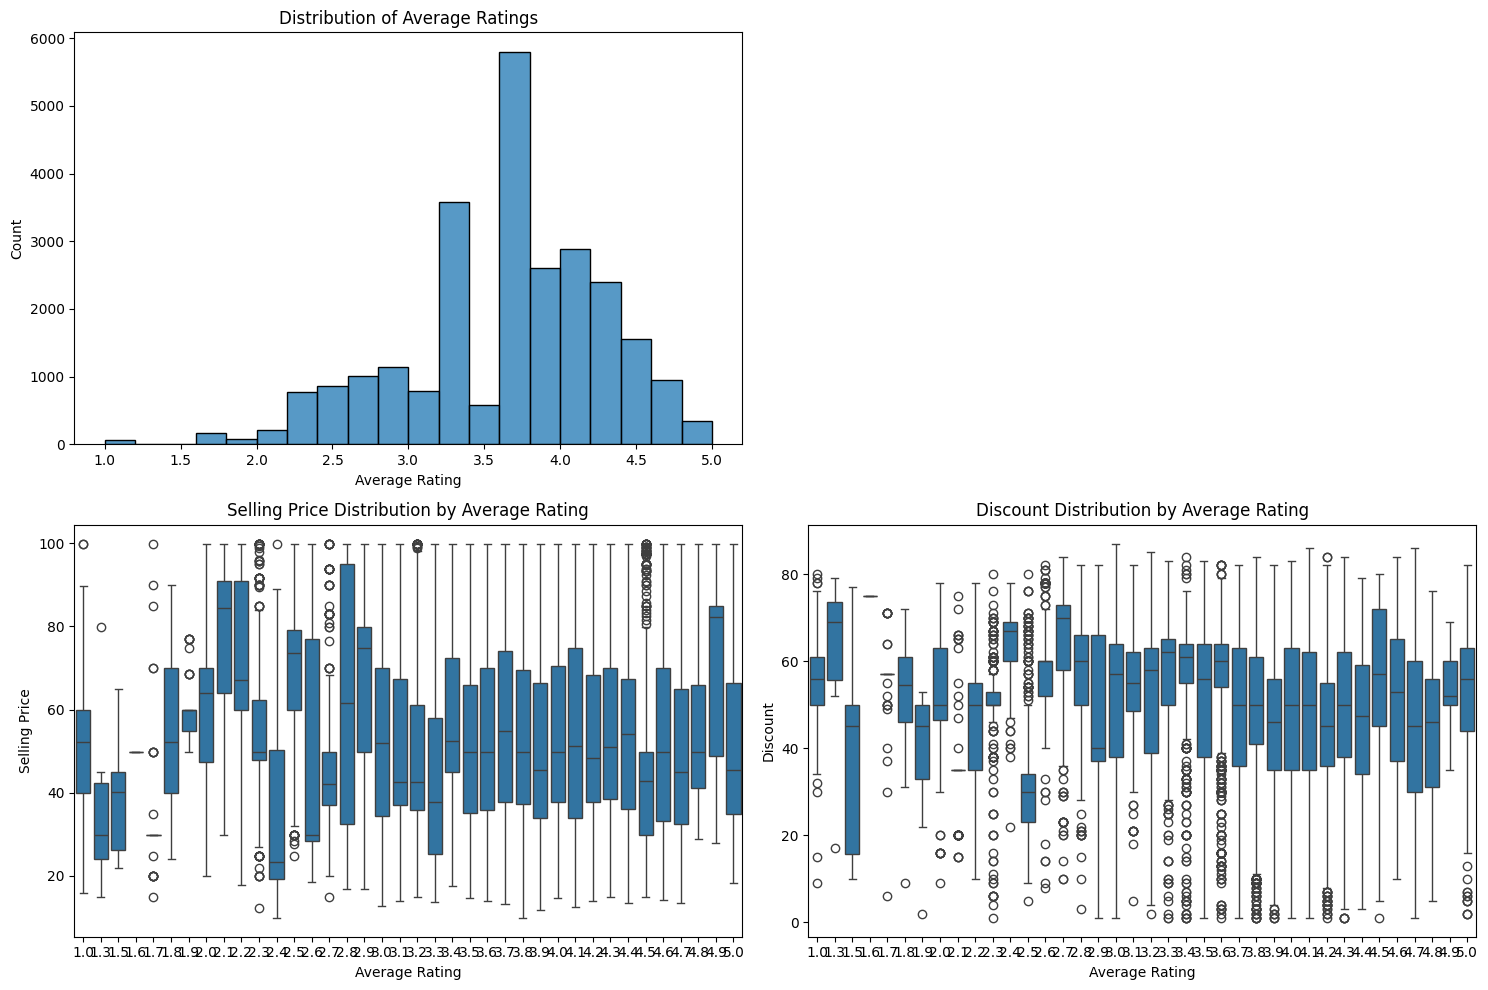

In [12]:
top_rated = clean_df.nlargest(10, 'average_rating')[['title', 'average_rating', 'brand']]
print("Top 10 Rated Products:")
display(top_rated)

top_selling_price = clean_df.nlargest(10, 'selling_price')[['title', 'selling_price', 'brand']]
print("\nTop 10 Products by Selling Price:")
display(top_selling_price)

top_discount = clean_df.nlargest(10, 'discount')[['title', 'discount', 'brand']]
print("\nTop 10 Products by Discount:")
display(top_discount)

top_sellers = clean_df['seller'].value_counts().head(10)
print("\nTop 10 Sellers:")
display(top_sellers)

top_brands = clean_df['brand'].value_counts().head(10)
print("\nTop 10 Brands:")
display(top_brands)


plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
sns.histplot(clean_df['average_rating'].dropna(), bins=20)
plt.title('Distribution of Average Ratings')
plt.xlabel('Average Rating')

plt.subplot(2, 2, 3)
sns.boxplot(data=clean_df, x='average_rating', y='selling_price')
plt.title('Selling Price Distribution by Average Rating')
plt.xlabel('Average Rating')
plt.ylabel('Selling Price')

plt.subplot(2, 2, 4)
sns.boxplot(data=clean_df, x='average_rating', y='discount')
plt.title('Discount Distribution by Average Rating')
plt.xlabel('Average Rating')
plt.ylabel('Discount')

plt.tight_layout()
plt.show()

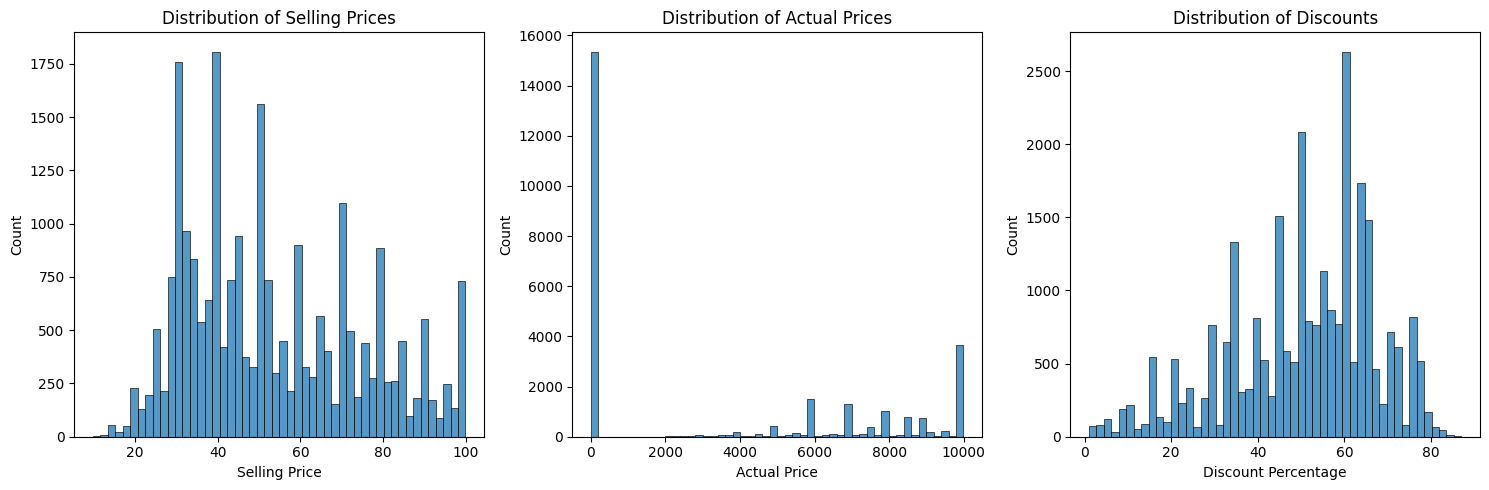


Price Statistics by Category:
                               mean  median        std  count
category                                                     
Bags, Wallets & Belts     25.851220    22.5  11.935894     41
Clothing and Accessories  54.034551    49.9  21.133955  23076
Footwear                  41.548292    32.0  18.001410    849
Toys                      18.900000    18.9        NaN      1


In [13]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.histplot(clean_df['selling_price'].dropna(), bins=50)
plt.title('Distribution of Selling Prices')
plt.xlabel('Selling Price')

plt.subplot(1, 3, 2)
sns.histplot(clean_df['actual_price'].dropna(), bins=50)
plt.title('Distribution of Actual Prices')
plt.xlabel('Actual Price')

plt.subplot(1, 3, 3)
sns.histplot(clean_df['discount'].dropna(), bins=50)
plt.title('Distribution of Discounts')
plt.xlabel('Discount Percentage')

plt.tight_layout()
plt.show()

print("\nPrice Statistics by Category:")
price_by_category = clean_df.groupby('category')['selling_price'].agg(['mean', 'median', 'std', 'count'])
print(price_by_category)

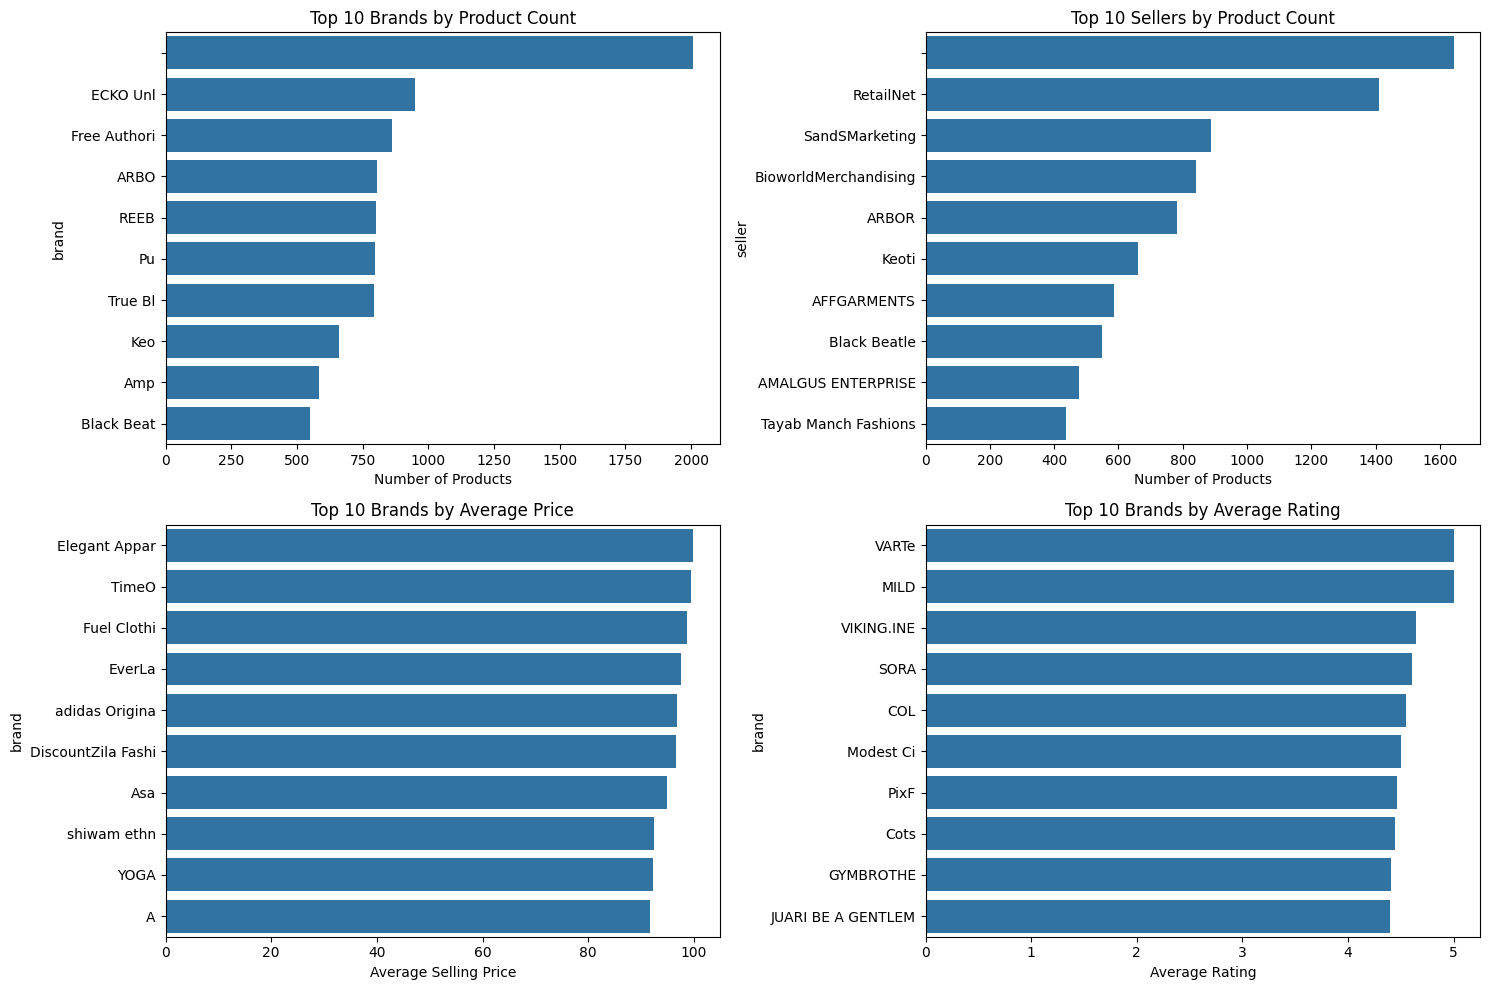

In [14]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
top_brands = clean_df['brand'].value_counts().head(10)
sns.barplot(x=top_brands.values, y=top_brands.index)
plt.title('Top 10 Brands by Product Count')
plt.xlabel('Number of Products')

plt.subplot(2, 2, 2)
top_sellers = clean_df['seller'].value_counts().head(10)
sns.barplot(x=top_sellers.values, y=top_sellers.index)
plt.title('Top 10 Sellers by Product Count')
plt.xlabel('Number of Products')

plt.subplot(2, 2, 3)
brand_avg_price = clean_df.groupby('brand')['selling_price'].mean().sort_values(ascending=False).head(10)
sns.barplot(x=brand_avg_price.values, y=brand_avg_price.index)
plt.title('Top 10 Brands by Average Price')
plt.xlabel('Average Selling Price')

plt.subplot(2, 2, 4)
brand_avg_rating = clean_df.groupby('brand')['average_rating'].mean().sort_values(ascending=False).head(10)
sns.barplot(x=brand_avg_rating.values, y=brand_avg_rating.index)
plt.title('Top 10 Brands by Average Rating')
plt.xlabel('Average Rating')

plt.tight_layout()
plt.show()

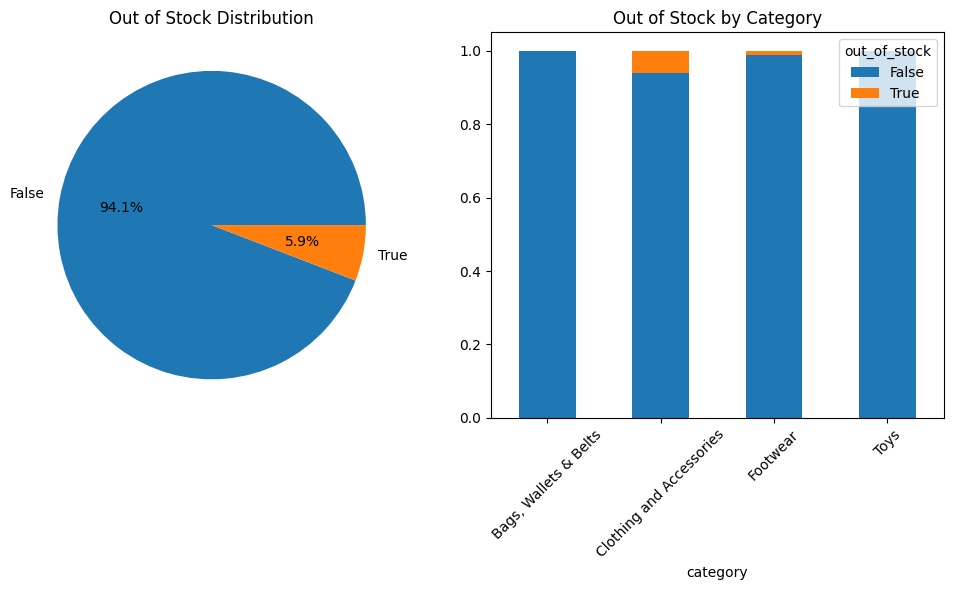

Out of Stock Percentage: 5.85%


In [15]:
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
stock_dist = clean_df['out_of_stock'].value_counts()
plt.pie(stock_dist.values, labels=stock_dist.index, autopct='%1.1f%%')
plt.title('Out of Stock Distribution')

plt.subplot(1, 2, 2)
stock_by_category = pd.crosstab(clean_df['category'], clean_df['out_of_stock'], normalize='index')
stock_by_category.plot(kind='bar', stacked=True, ax=plt.gca()) # Plot on the current axes
plt.title('Out of Stock by Category')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

print(f"Out of Stock Percentage: {(clean_df['out_of_stock'].sum() / len(clean_df)) * 100:.2f}%")

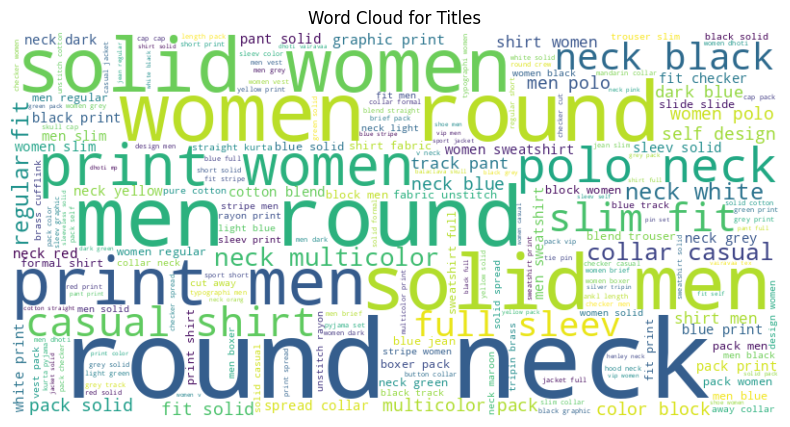

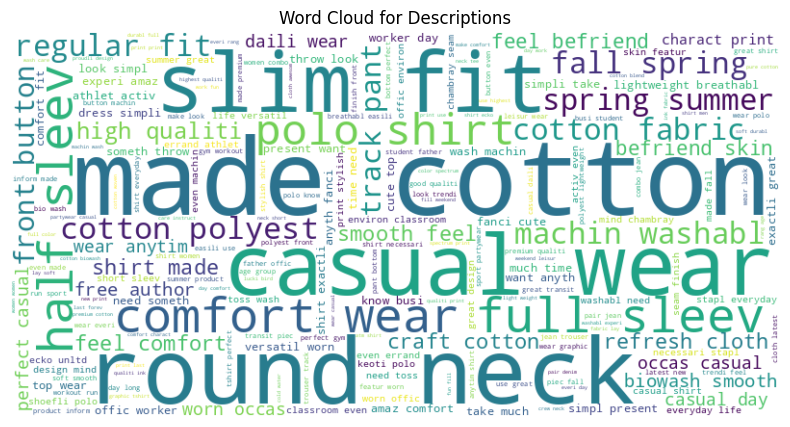

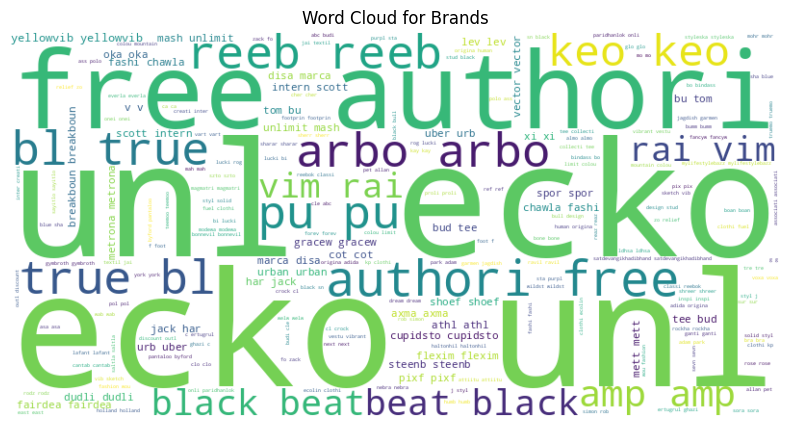

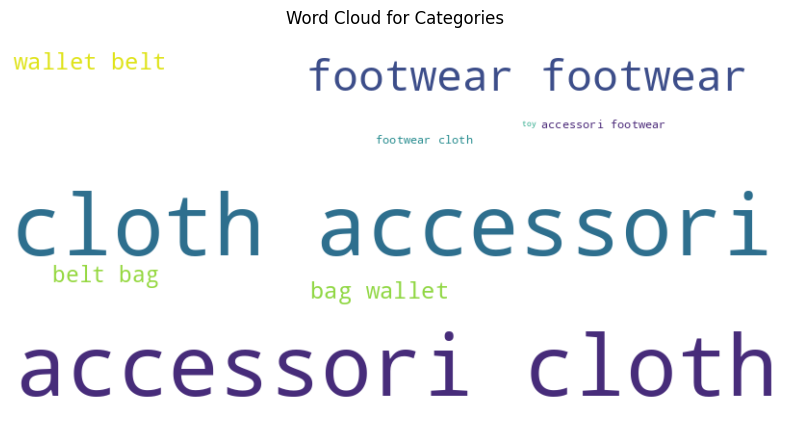

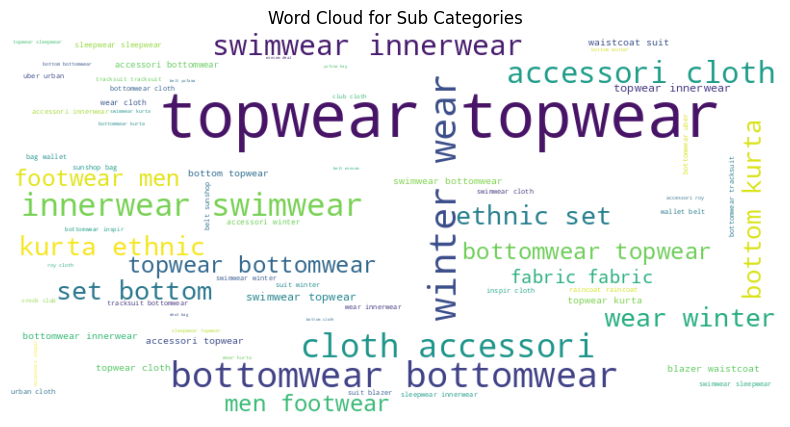

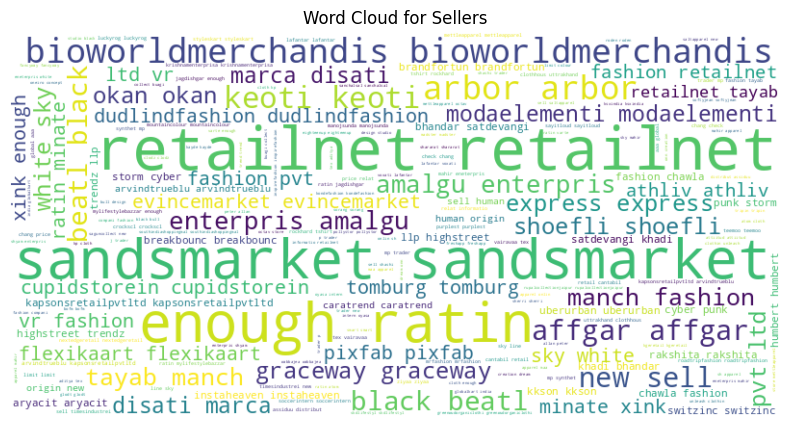

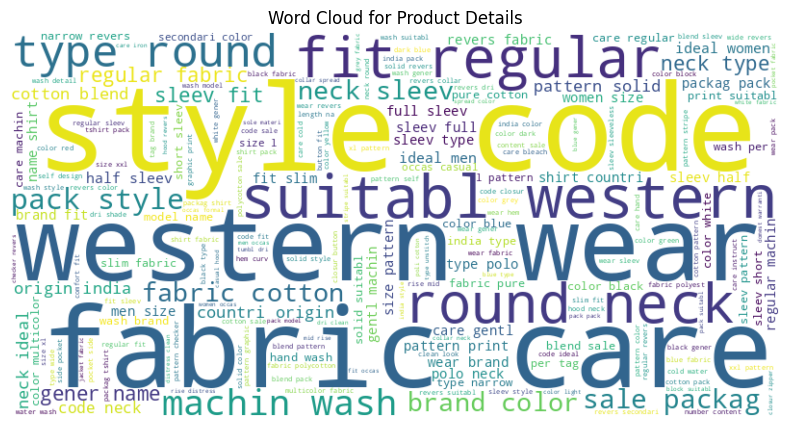

In [16]:
from wordcloud import WordCloud
#This just helps to visualise the wordcloud

def generate_wordcloud(x, title):
    all_words = [word for tokens in x.dropna() for word in tokens]
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(all_words))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

generate_wordcloud(processed_df['title'], 'Word Cloud for Titles')
generate_wordcloud(processed_df['description'], 'Word Cloud for Descriptions')
generate_wordcloud(processed_df['brand'], 'Word Cloud for Brands')
generate_wordcloud(processed_df['category'], 'Word Cloud for Categories')
generate_wordcloud(processed_df['sub_category'], 'Word Cloud for Sub Categories')
generate_wordcloud(processed_df['seller'], 'Word Cloud for Sellers')
generate_wordcloud(processed_df['product_details'], 'Word Cloud for Product Details')